In [123]:
import numpy as np
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import great_tables as tg
import altair as alt
from ibis.selectors import First

In [124]:
df_path = r'../DATASETS/Mall_Customers.csv'

In [125]:
df = pl.read_csv(df_path)

In [126]:
fig = px.scatter(
    df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)').update_layout(
    width=1600,
    height=700,
)
fig.show()

In [127]:
df.columns

['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [128]:
X = df.select(cs.exclude(['Spending Score (1-100)']))

In [129]:
y = df.get_column('Spending Score (1-100)')

In [130]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [131]:
column_transformer = ColumnTransformer(
    transformers=[
        ('encoded', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), ['Genre'])],
        remainder='passthrough'
)

In [132]:
X_encoded = column_transformer.fit_transform(X)

In [133]:
feature_names = column_transformer.get_feature_names_out()

In [134]:
X_encoded = pl.DataFrame(X_encoded, schema=list(feature_names))

In [135]:
X_encoded

encoded__Genre_Male,remainder__CustomerID,remainder__Age,remainder__Annual Income (k$)
f64,f64,f64,f64
1.0,1.0,19.0,15.0
1.0,2.0,21.0,15.0
0.0,3.0,20.0,16.0
0.0,4.0,23.0,16.0
0.0,5.0,31.0,17.0
…,…,…,…
0.0,196.0,35.0,120.0
0.0,197.0,45.0,126.0
1.0,198.0,32.0,126.0


In [136]:
from sklearn.model_selection import train_test_split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [138]:
from sklearn.preprocessing import StandardScaler

In [139]:
scaler = StandardScaler()

In [140]:
X_train_scaled = scaler.fit_transform(X_train)

In [141]:
X_test_scaled = scaler.transform(X_test)

In [142]:
from sklearn.neighbors import KNeighborsRegressor

In [143]:
knn_regressor = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

In [144]:
knn_regressor.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_jobs=-1)

In [145]:
predictions = knn_regressor.predict(X_test_scaled)

In [146]:
pl.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Error': (predictions - y_test)
})

Actual,Predicted,Error
i64,f64,f64
52,49.4,-2.6
79,68.2,-10.8
4,26.4,22.4
1,67.0,66.0
11,49.6,38.6
…,…,…
56,38.4,-17.6
88,72.2,-15.8
73,82.2,9.2


In [147]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

In [148]:
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
RMSE = root_mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)

In [149]:
print(f'Mean Squared Error: {MSE}\nMean Absolute Error: {MAE}\nRoot Mean Squared Error: {RMSE}\nR2 Score: {R2}')

Mean Squared Error: 400.409
Mean Absolute Error: 13.594999999999999
Root Mean Squared Error: 20.010222387569808
R2 Score: 0.1882065525910307


In [150]:
results_df = pl.DataFrame({
    'Actual': y_test.to_list(),
    'Predicted': predictions
})

# Scatter plot
fig_actual_vs_pred = px.scatter(
    results_df,
    x='Actual',
    y='Predicted',
    title='Actual vs Predicted Values',
    labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'},
    width=800,
    height=500
)

fig_actual_vs_pred.add_shape(
    type='line',
    x0=results_df['Actual'].min(),
    y0=results_df['Actual'].min(),
    x1=results_df['Actual'].max(),
    y1=results_df['Actual'].max(),
    line=dict(color='red', dash='dash')
)

fig_actual_vs_pred.show()

In [151]:
results_df = results_df.with_columns(
    (results_df['Predicted'] - results_df['Actual']).alias('Residuals')
)


fig_residuals = px.scatter(
    results_df,
    x='Actual',
    y='Residuals',
    title='Residual Plot',
    labels={'Actual': 'Actual Values', 'Residuals': 'Residuals'},
    width=800,
    height=500
)

fig_residuals.add_shape(
    type='line',
    x0=results_df['Actual'].min(),
    y0=0,
    x1=results_df['Actual'].max(),
    y1=0,
    line=dict(color='red', dash='dash')
)

fig_residuals.show()

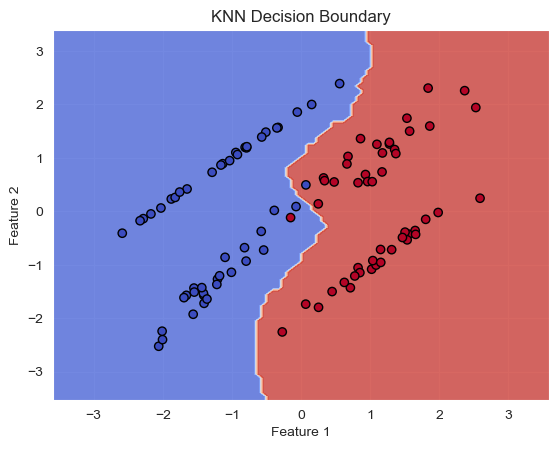

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

X, y = make_classification(n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# Meshgrid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
plt.title("KNN Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [153]:
from sklearn.model_selection import GridSearchCV

In [166]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

In [169]:
grid_model = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1)

In [170]:
grid_model.fit(X_train_scaled, y_train)

C:\Users\Zygim\anaconda3\envs\Analytic_2024_12_21\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']})

In [171]:
predictions = grid_model.predict(X_test_scaled)

In [172]:
pl.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Error': (predictions - y_test)
})

Actual,Predicted,Error
i64,i64,i64
52,55,3
79,73,-6
4,46,42
1,75,74
11,9,-2
…,…,…
56,46,-10
88,40,-48
73,75,2


In [175]:
MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = root_mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)

In [176]:
print(f'Mean Squared Error: {MSE}\nMean Absolute Error: {MAE}\nRoot Mean Squared Error: {RMSE}\nR2 Score: {R2}')

Mean Squared Error: 801.575
Mean Absolute Error: 19.475
Root Mean Squared Error: 28.31209988679752
R2 Score: -0.6251216446354717


In [177]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [178]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('knn', KNeighborsRegressor(n_neighbors=5, n_jobs=-1))
])

In [189]:
param_grid = {
    'poly__degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
}

In [190]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1
)

In [191]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21],
                         'knn__weights': ['uniform', 'distance'],
                         'poly__degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [192]:
grid_search.best_params_

{'knn__algorithm': 'ball_tree',
 'knn__n_neighbors': 11,
 'knn__weights': 'distance',
 'poly__degree': 2}

In [193]:
grid_search.best_score_

np.float64(0.19165501861556297)

In [194]:
predictions = grid_search.predict(X_test_scaled)

In [195]:
pl.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Error': (predictions - y_test)
})

Actual,Predicted,Error
i64,f64,f64
52,51.272526,-0.727474
79,66.616997,-12.383003
4,36.019652,32.019652
1,63.020966,62.020966
11,43.983205,32.983205
…,…,…
56,48.571339,-7.428661
88,70.238448,-17.761552
73,77.795039,4.795039


In [197]:
MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = root_mean_squared_error(y_test , predictions)
R2 = r2_score(y_test, predictions)

In [198]:
print(f'Mean Squared Error: {MSE}\nMean Absolute Error: {MAE}\nRoot Mean Squared Error: {RMSE}\nR2 Score: {R2}')

Mean Squared Error: 454.4272377340135
Mean Absolute Error: 15.153330638771887
Root Mean Squared Error: 21.317299025298997
R2 Score: 0.07868940529151425
